# Model Evaluation
Evaluate the performance of BGRU and GAN models for the repective Hong Kong and United States' stock market

In [61]:
import copy
import os
import re
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_percentage_error

In [62]:
EVALUATION_DIAGRAM_PATH = "./diagrams/model/evaluation"
SCALER_PATH = "./scaler"

# stocks model checkpoint paths
HK_MODELS_CHECKPOINT_PATH = "./model/hk"
US_MODELS_CHECKPOINT_PATH = "./model/us"

In [63]:
# bgru
hk_bgru_file_path = "{}/bgru.h5".format(HK_MODELS_CHECKPOINT_PATH)
hk_bgru_train_history_file_path = "{}/bgru_history/bgru_training_history.npy".format(HK_MODELS_CHECKPOINT_PATH)

us_bgru_file_path = "{}/bgru.h5".format(US_MODELS_CHECKPOINT_PATH)
us_bgru_train_history_file_path = "{}/bgru_history/bgru_training_history.npy".format(US_MODELS_CHECKPOINT_PATH)

# gan
hk_gan_file_path = "{}/gan.h5".format(HK_MODELS_CHECKPOINT_PATH)
hk_gan_train_history_file_path = "{}/gan_training_history.npy".format(HK_MODELS_CHECKPOINT_PATH)

us_gan_file_path = "{}/gan.h5".format(US_MODELS_CHECKPOINT_PATH)
us_gan_train_history_file_path = "{}/gan_training_history.npy".format(US_MODELS_CHECKPOINT_PATH)

# The model.evaluate() returns (in sequence):
## 1. loss (mean_squared_error)
## 2. mean_absolute_error
## 3. root_mean_squared_error
## 4. mean_absolute_percentage_error
evaluation_fields_name = [
    "loss (mean_squared_error)",
    "mean_absolute_error",
    "root_mean_squared_error",
    "mean_absolute_percentage_error"
]

def create_dir_if_not_exist(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname, exist_ok=True)

def is_stock_hk(stock_name):
    return ".HK" in stock_name

In [64]:
# plot diagrams function
def plot_predicted_price(predicted_y, actual_y, title, predicted_y_legend_label, actual_y_legend_label,
                                   price_currency):

    plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
    plt.plot(actual_y, label=actual_y_legend_label)
    plt.plot(predicted_y, label=predicted_y_legend_label)
    plt.xlabel('Trading Day')
    plt.ylabel(price_currency)
    plt.title(title)
    plt.legend()
    create_dir_if_not_exist(EVALUATION_DIAGRAM_PATH)
    plt.savefig('{}/{}.png'.format(EVALUATION_DIAGRAM_PATH, plt.gca().get_title()))
    plt.show()

### Import datasets

In [65]:
evaluation_stocks_path = "./data/processed/stocks_for_evaluate/"
template_filename_test_x = "{}/{}_test_X.npy"
template_filename_test_y = "{}/{}_test_y.npy"

npys = [x for x in os.listdir(evaluation_stocks_path) if x.endswith('.npy')]

# get stocks name
fns = list(dict.fromkeys([
    re.sub(r'(_test_y|_test_X)', "",os.path.splitext(os.path.basename(x))[0]) for x in npys
]))

d = {}
for i in range(len(npys)):
    d[npys[i].replace(".npy", "")] = np.load(evaluation_stocks_path + npys[i])

# check if all the evaluation stock data has been imported
assert len(d) == len(fns) * 2

# Show the read files
d["AAPL_test_X"].shape

(497, 30, 9)

In [66]:
# Get the stocks' name from raw data
stock_name_hk = pd.read_csv("data/raw/HSI Constituents list_filtered.csv")
stock_name_hk = stock_name_hk[["Name", "Symbol"]]

stock_name_us = pd.read_csv("data/raw/S&P 500 Constituents_filtered.csv")
stock_name_us = stock_name_us[["Name", "Symbol"]]

stock_name_eva = pd.read_csv("data/raw/Stocks for evaluation.csv")
stock_name_eva = stock_name_eva[["Name", "Symbol"]]

stock_names = pd.concat([stock_name_us, stock_name_hk, stock_name_eva], ignore_index=True)
stock_names

Name   Symbol
0                      Wabtec      WAB
1                 Ross Stores     ROST
2                         UDR      UDR
3   Martin Marietta Materials      MLM
4             FMC Corporation      FMC
..                        ...      ...
95                 CHINA LIFE  2628.HK
96                    CM BANK  3968.HK
97              BANK OF CHINA  3988.HK
98     Standard Chartered PLC  2888.HK
99                  Atlassian     TEAM

[100 rows x 2 columns]

### Import scaler

In [67]:
joblibs = [x for x in os.listdir(SCALER_PATH) if x.endswith('.joblib')]

# get scaler names
scaler_names = [os.path.splitext(os.path.basename(x))[0] for x in joblibs]

scalers = {}

for i in range(len(scaler_names)):
    scalers[scaler_names[i]] = joblib.load(SCALER_PATH + "/" + joblibs[i])

# Show the read scaler
print(scalers["{}.X_scaler".format("1038.HK")])
print(scalers["{}.y_scaler".format("1038.HK")])

MinMaxScaler(feature_range=(-1, 1))
MinMaxScaler(feature_range=(-1, 1))


### Import models

In [68]:
hk_bgru = load_model(hk_bgru_file_path)
# hk_gan = load_model(hk_gan_file_path)
us_bgru = load_model(us_bgru_file_path)
# us_gan = load_model(us_gan_file_path)


### Predicts and evaluate the stocks

In [69]:
df_eva_metrics_list = []


In [70]:
def predict_and_evaluate(model, model_name, is_model_hk):
    """
    Predict and evaluate the model with stocks
    :param model: tf.Keras.Model
    :param model_name:  str, model name
    :param is_model_hk: boolean, indicates whether the model is trained for HK market
    """
    global df_eva_metrics
    for i in range(len(fns)):
        tmp_stock = fns[i]

        tmp_eva_result = model.evaluate(x=d["{}_test_X".format(tmp_stock)], y=d["{}_test_y".format(tmp_stock)])
        tmp_predict_result = model.predict(x=d["{}_test_X".format(tmp_stock)])
        tmp_scaler_y = scalers["{}.y_scaler".format(tmp_stock)]

        plot_predicted_price(
            predicted_y=tmp_scaler_y.inverse_transform(
                tmp_predict_result
            ),
            actual_y=tmp_scaler_y.inverse_transform(
                d["{}_test_y".format(tmp_stock)]
            ),
            # title="CK Infrastructure Holdings Limited (1038.HK) Stock Price Prediction with BGRU",
            title="{} ({}) Stock Price Prediction with {} {}".format(
                stock_names[stock_names["Symbol"] == tmp_stock]["Name"].item(),
                tmp_stock,
                "HK" if is_model_hk else "US",
                model_name
            ),
            predicted_y_legend_label="{} Predicted Closing Price".format(model_name),
            actual_y_legend_label="Actual Closing Price",
            price_currency="HKD" if is_stock_hk(tmp_stock) else "USD"
        )

        # update MAPE value
        tmp_eva_result[-1] = mean_absolute_percentage_error(
            y_true=tmp_scaler_y.inverse_transform(
                        d["{}_test_y".format(tmp_stock)]
            ),
            y_pred=tmp_scaler_y.inverse_transform(
                        tmp_predict_result
            ),
        )

        df_eva_metrics_list.append(["{} ({})".format(model_name, "HK" if is_model_hk else "US"), tmp_stock] + tmp_eva_result)

#### HK models (BGRU & GAN) predicting the stocks
##### BGRU

15/15 [==============================] - 1s 36ms/step - loss: 0.0181 - mean_absolute_error: 0.0974 - root_mean_squared_error: 0.1346 - mean_absolute_percentage_error: 463.0770

15/15 [==============================] - 1s 38ms/step - loss: 0.0449 - mean_absolute_error: 0.1628 - root_mean_squared_error: 0.2118 - mean_absolute_percentage_error: 89.6572

16/16 [==============================] - 0s 29ms/step - loss: 0.0119 - mean_absolute_error: 0.0923 - root_mean_squared_error: 0.1093 - mean_absolute_percentage_error: 29.7209

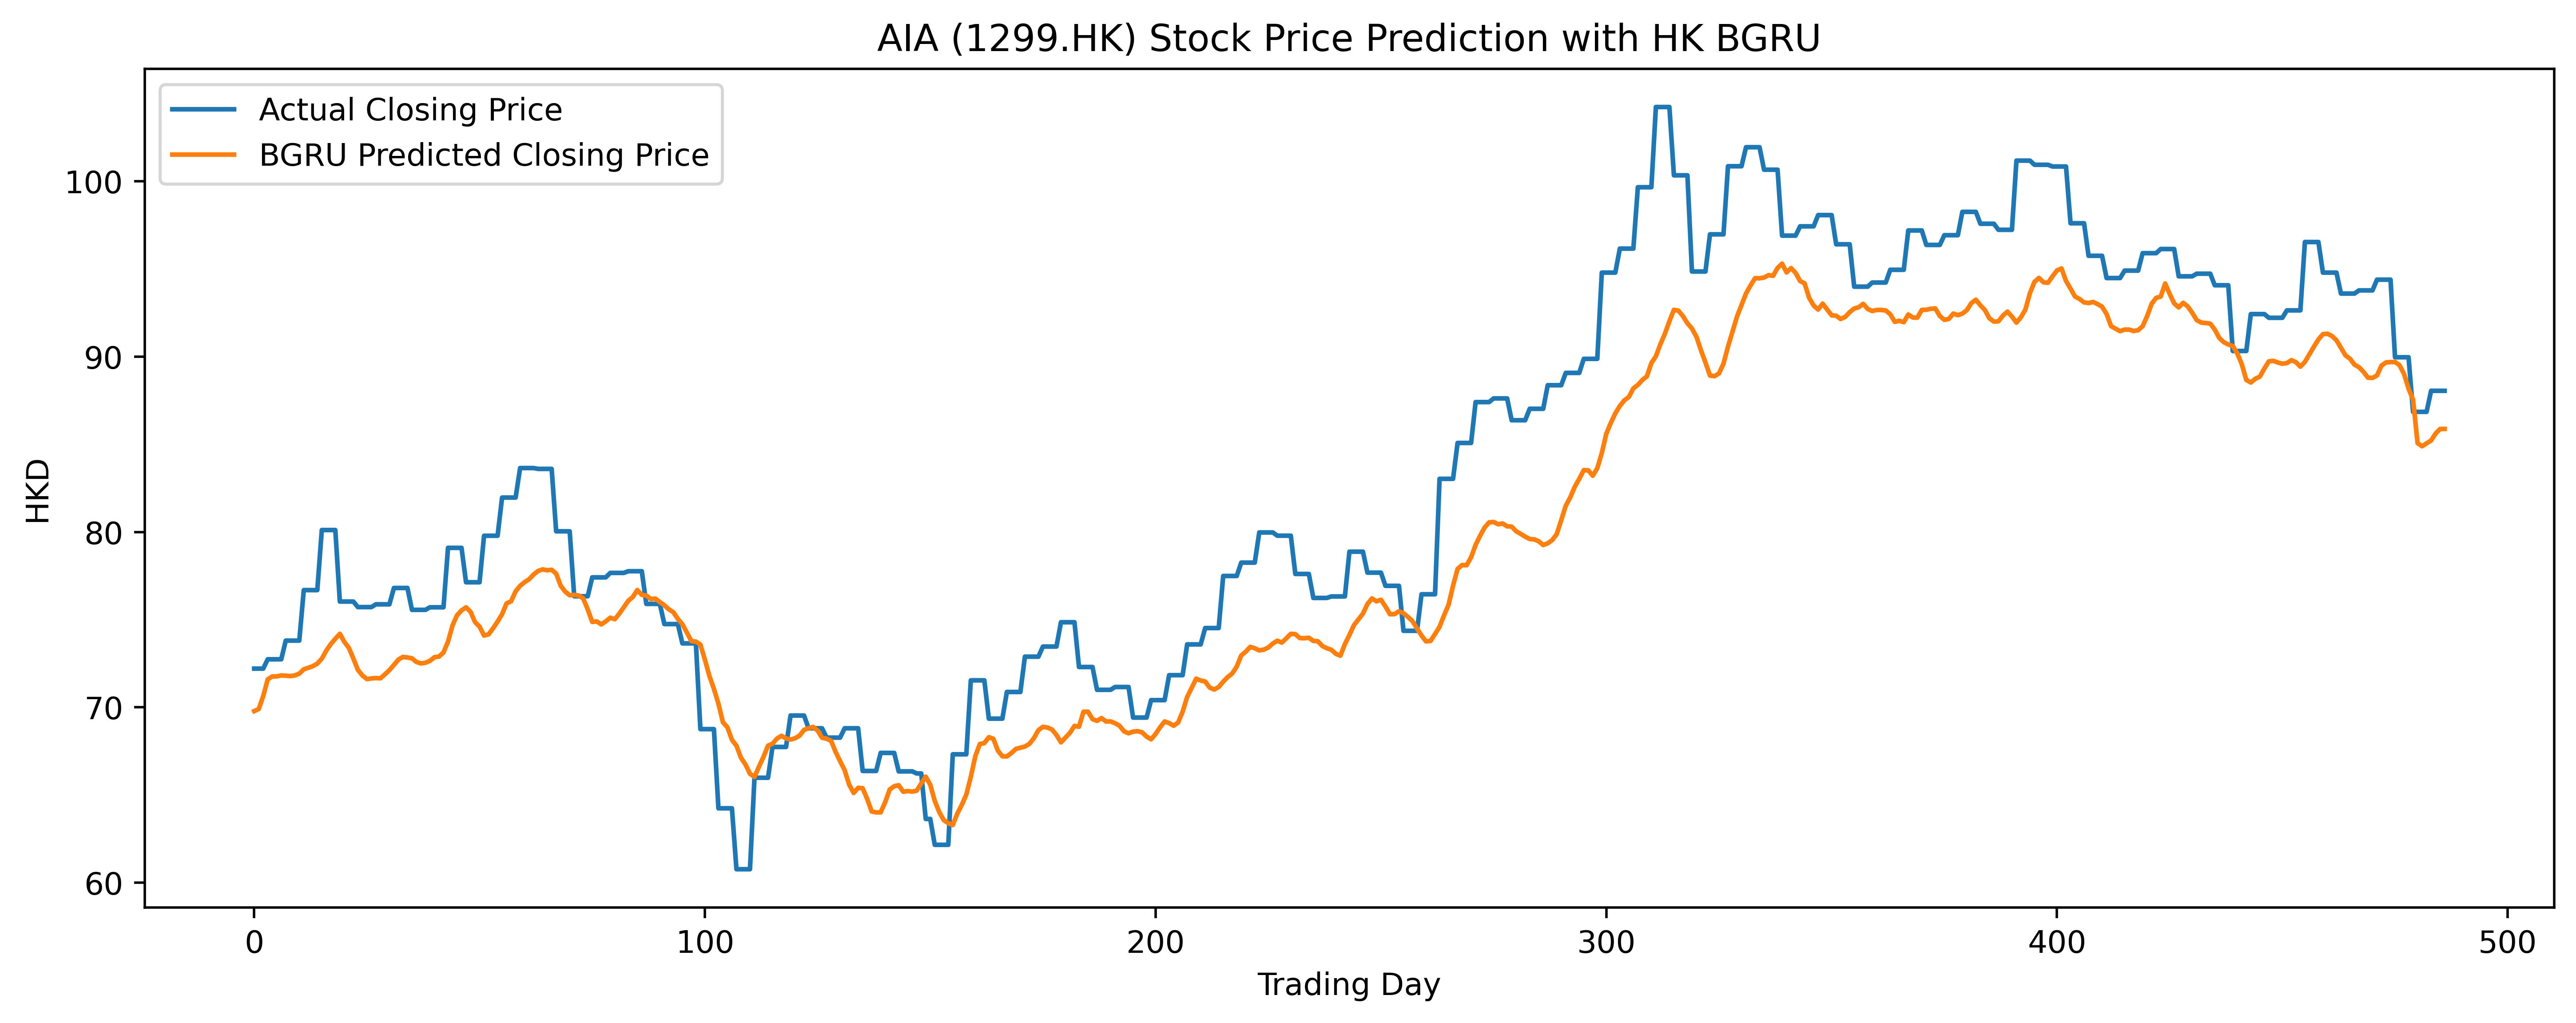

16/16 [==============================] - 1s 36ms/step - loss: 0.0088 - mean_absolute_error: 0.0782 - root_mean_squared_error: 0.0938 - mean_absolute_percentage_error: 32.9357

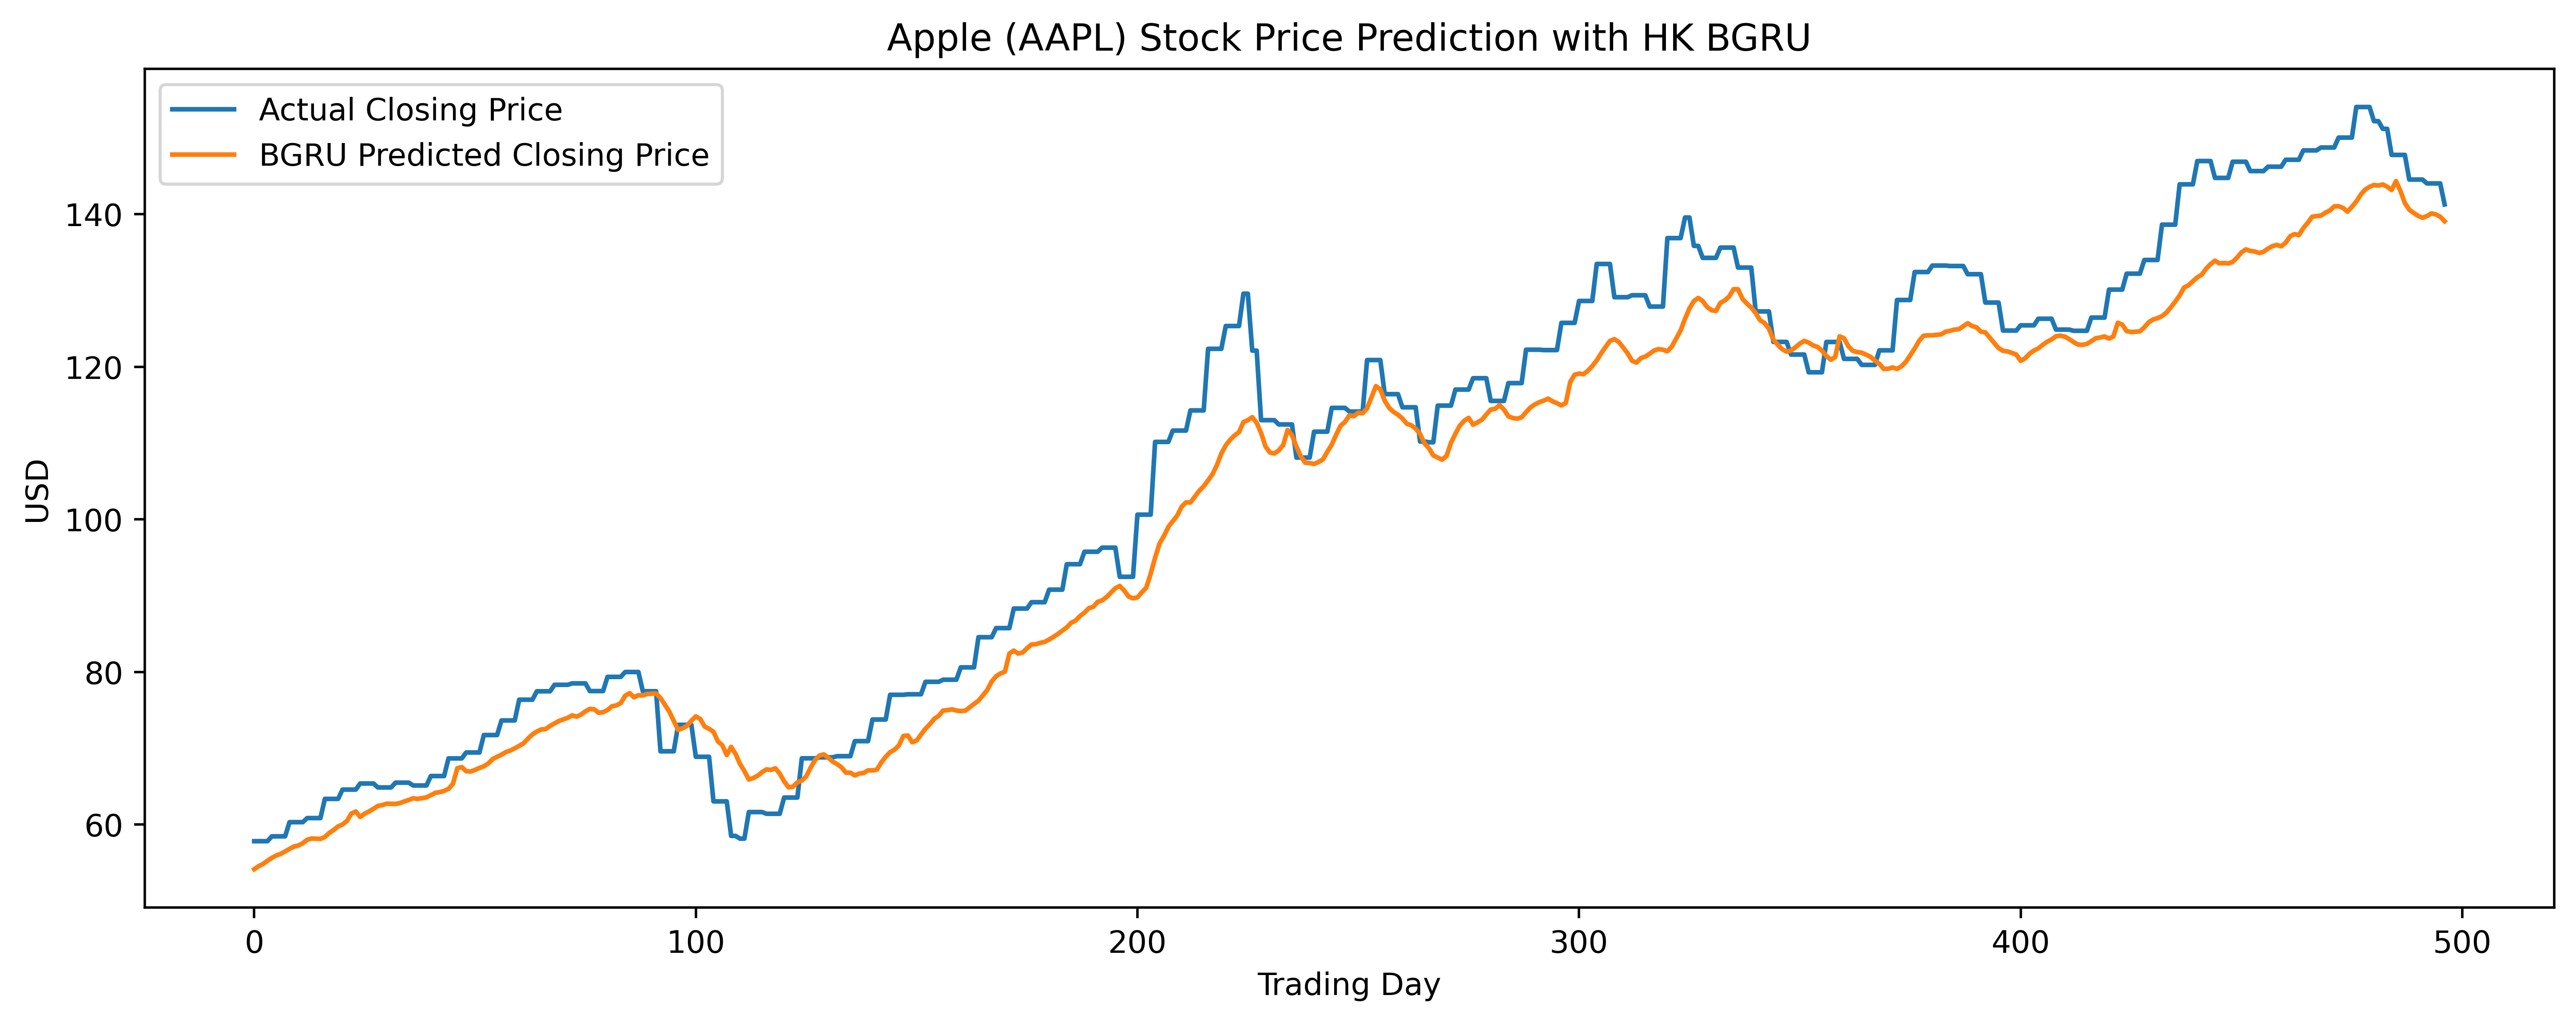

16/16 [==============================] - 0s 21ms/step - loss: 0.0203 - mean_absolute_error: 0.1165 - root_mean_squared_error: 0.1425 - mean_absolute_percentage_error: 437.8636

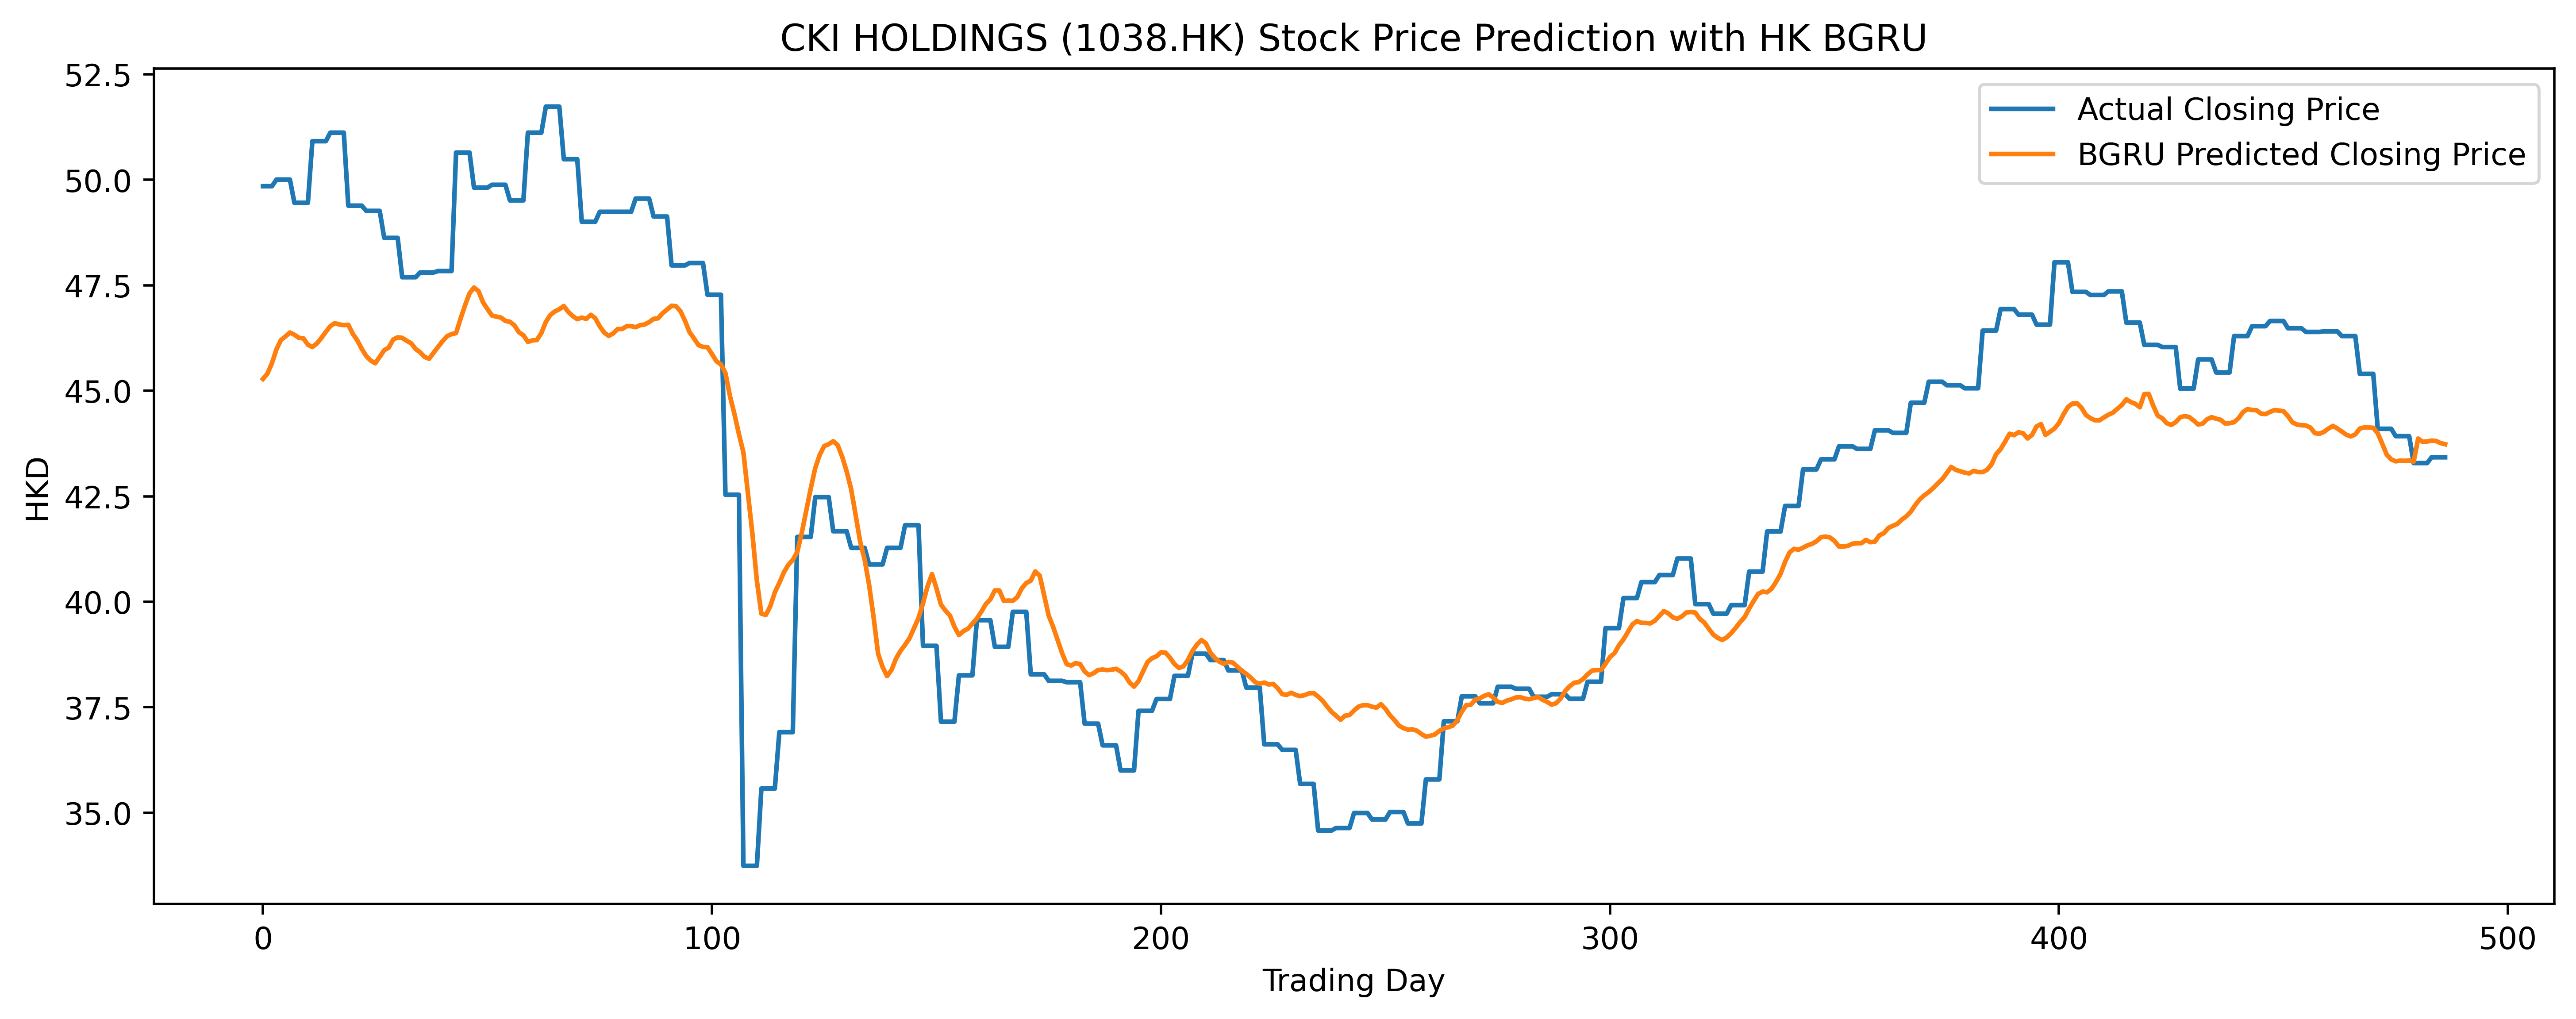

16/16 [==============================] - 0s 23ms/step - loss: 0.0045 - mean_absolute_error: 0.0542 - root_mean_squared_error: 0.0673 - mean_absolute_percentage_error: 55.4676

In [71]:
predict_and_evaluate(hk_bgru, "BGRU", True)

##### GAN

In [72]:
predict_and_evaluate(hk_gan, "GAN", True)

NameError: name 'hk_gan' is not defined

#### US models (BGRU & GAN) predicting the stocks
##### BGRU

15/15 [==============================] - 1s 35ms/step - loss: 0.0055 - mean_absolute_error: 0.0534 - root_mean_squared_error: 0.0741 - mean_absolute_percentage_error: 91.6469

15/15 [==============================] - 1s 34ms/step - loss: 0.0102 - mean_absolute_error: 0.0780 - root_mean_squared_error: 0.1012 - mean_absolute_percentage_error: 30.5504

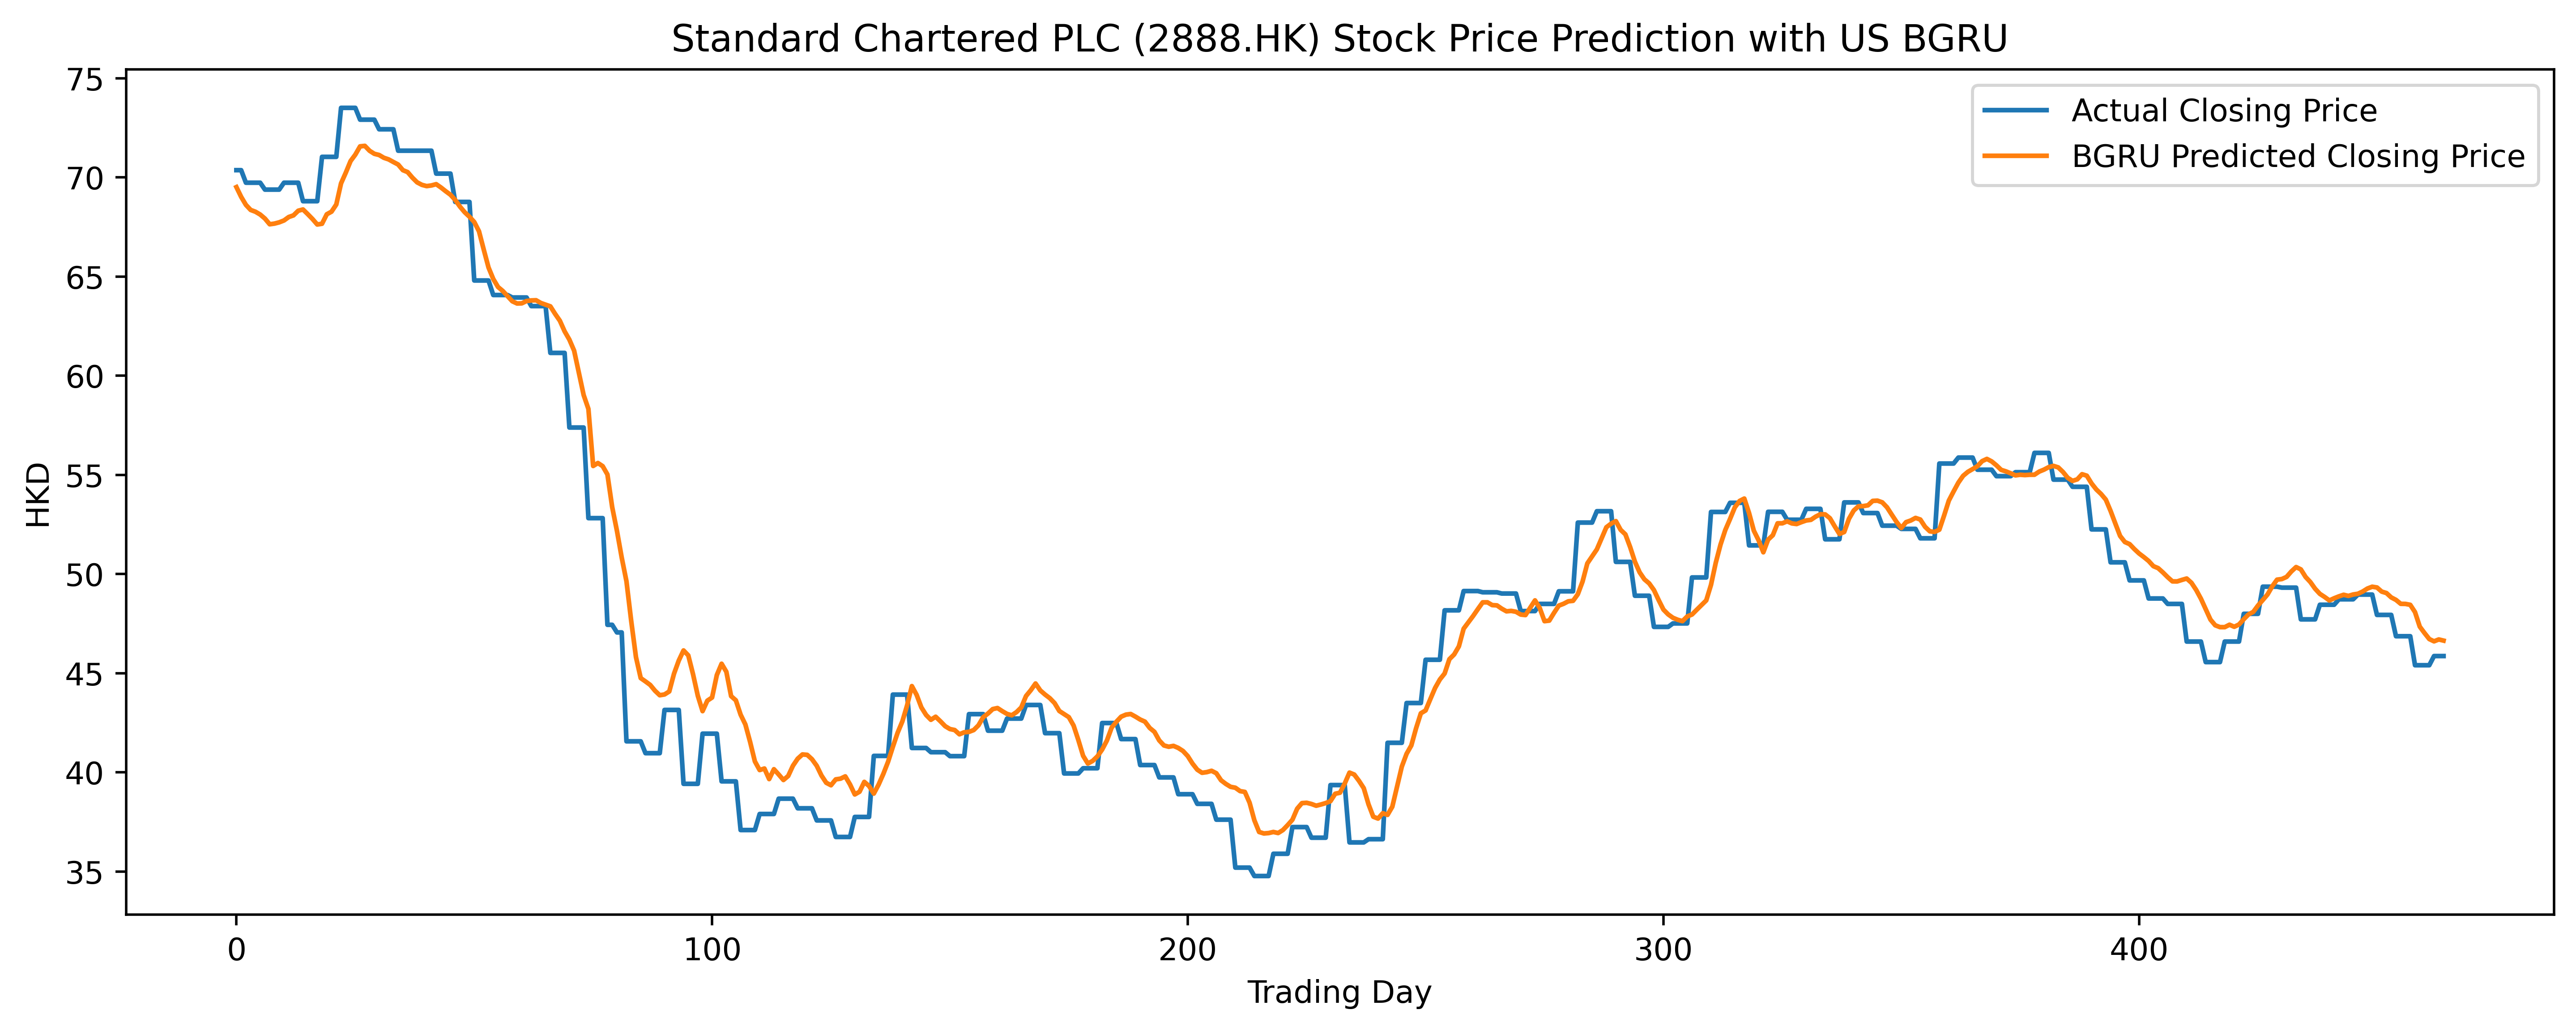

16/16 [==============================] - 1s 31ms/step - loss: 0.0045 - mean_absolute_error: 0.0552 - root_mean_squared_error: 0.0674 - mean_absolute_percentage_error: 19.3788

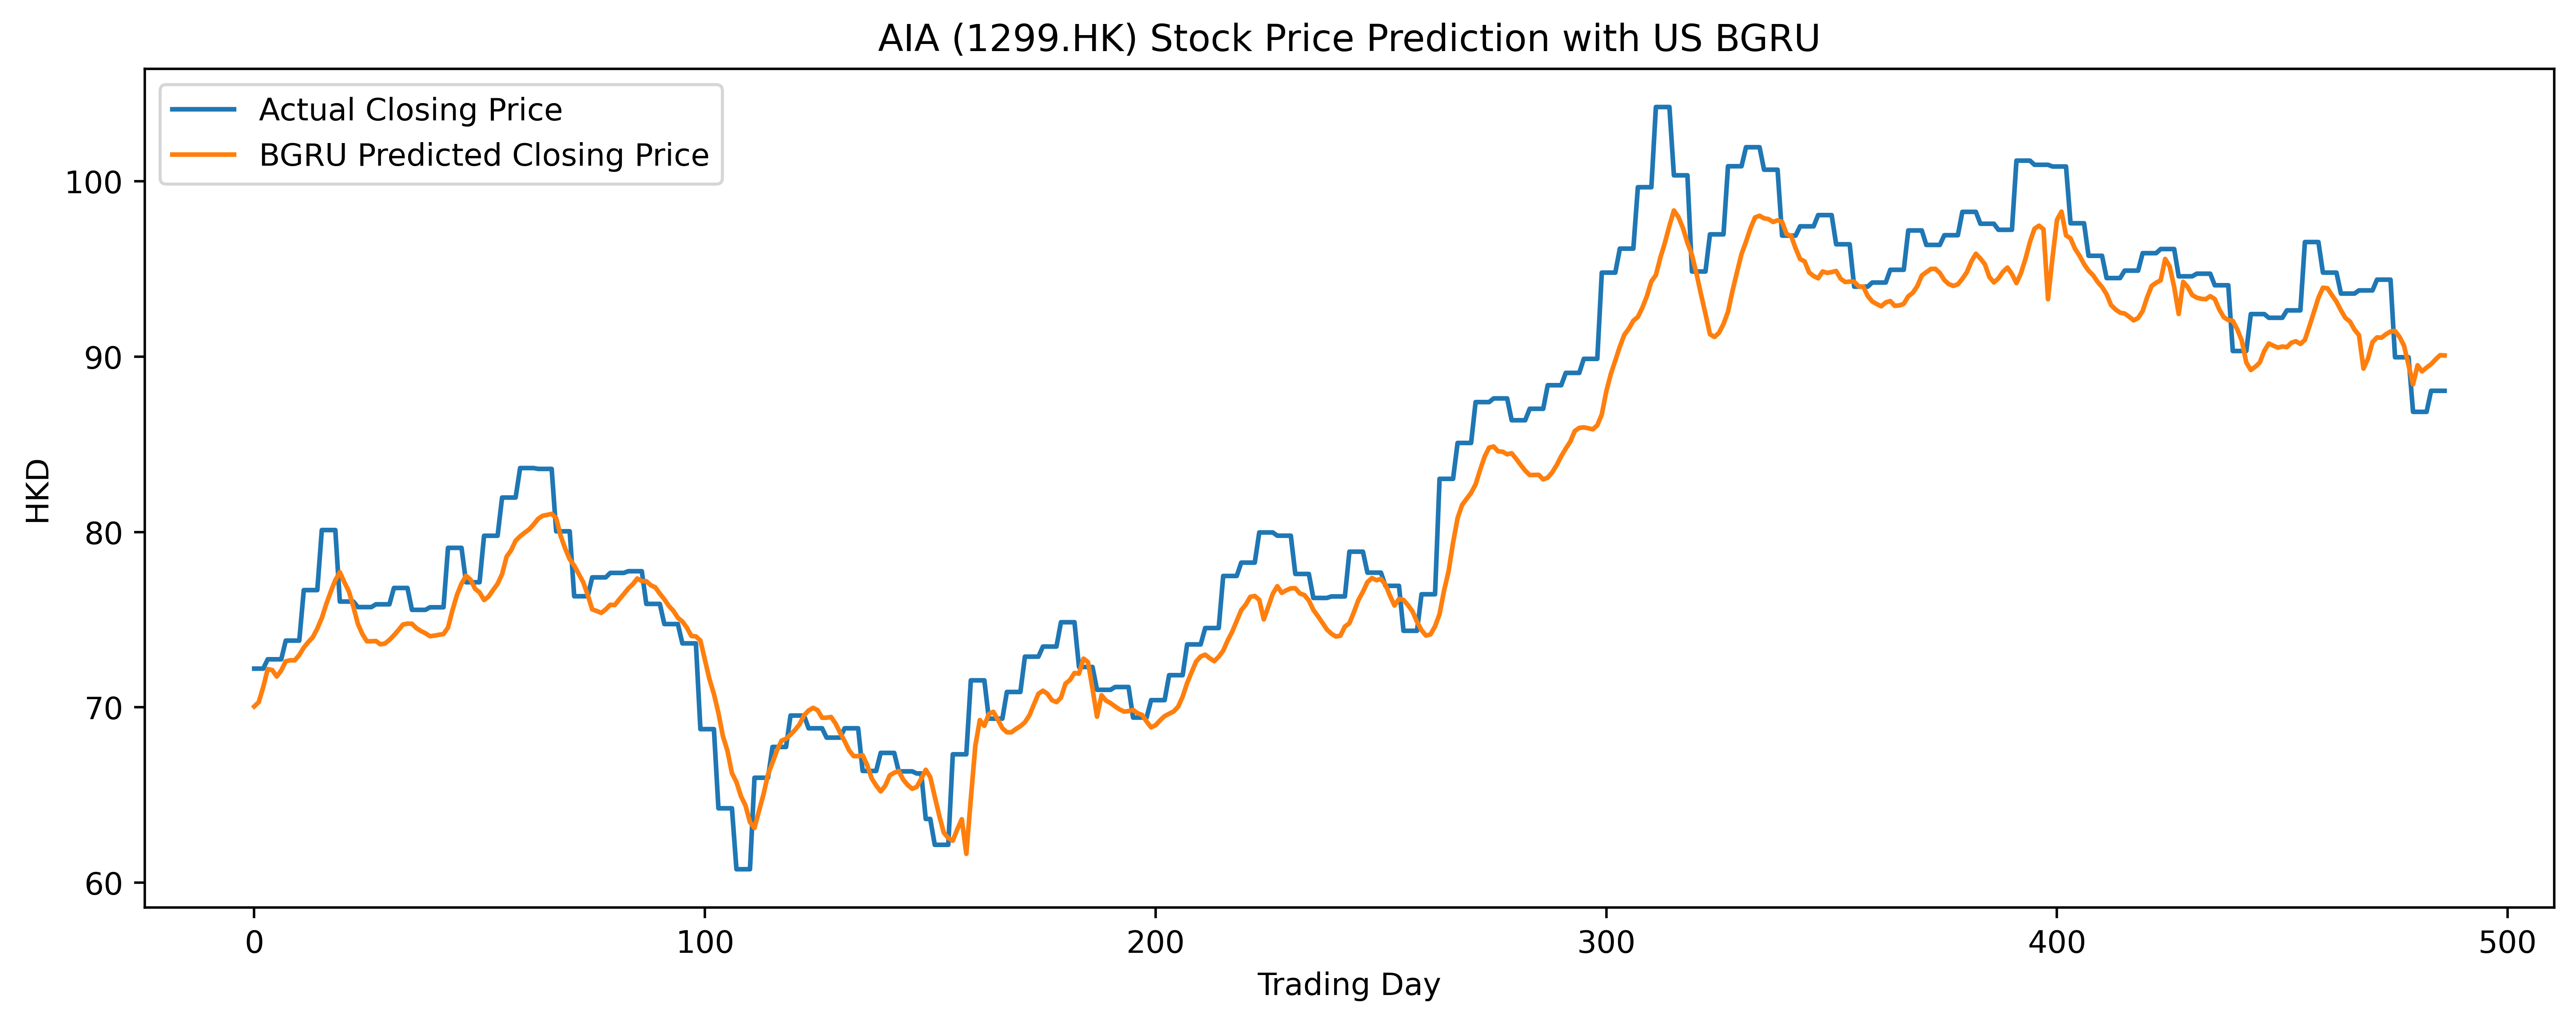

16/16 [==============================] - 0s 22ms/step - loss: 0.0064 - mean_absolute_error: 0.0675 - root_mean_squared_error: 0.0800 - mean_absolute_percentage_error: 31.7672

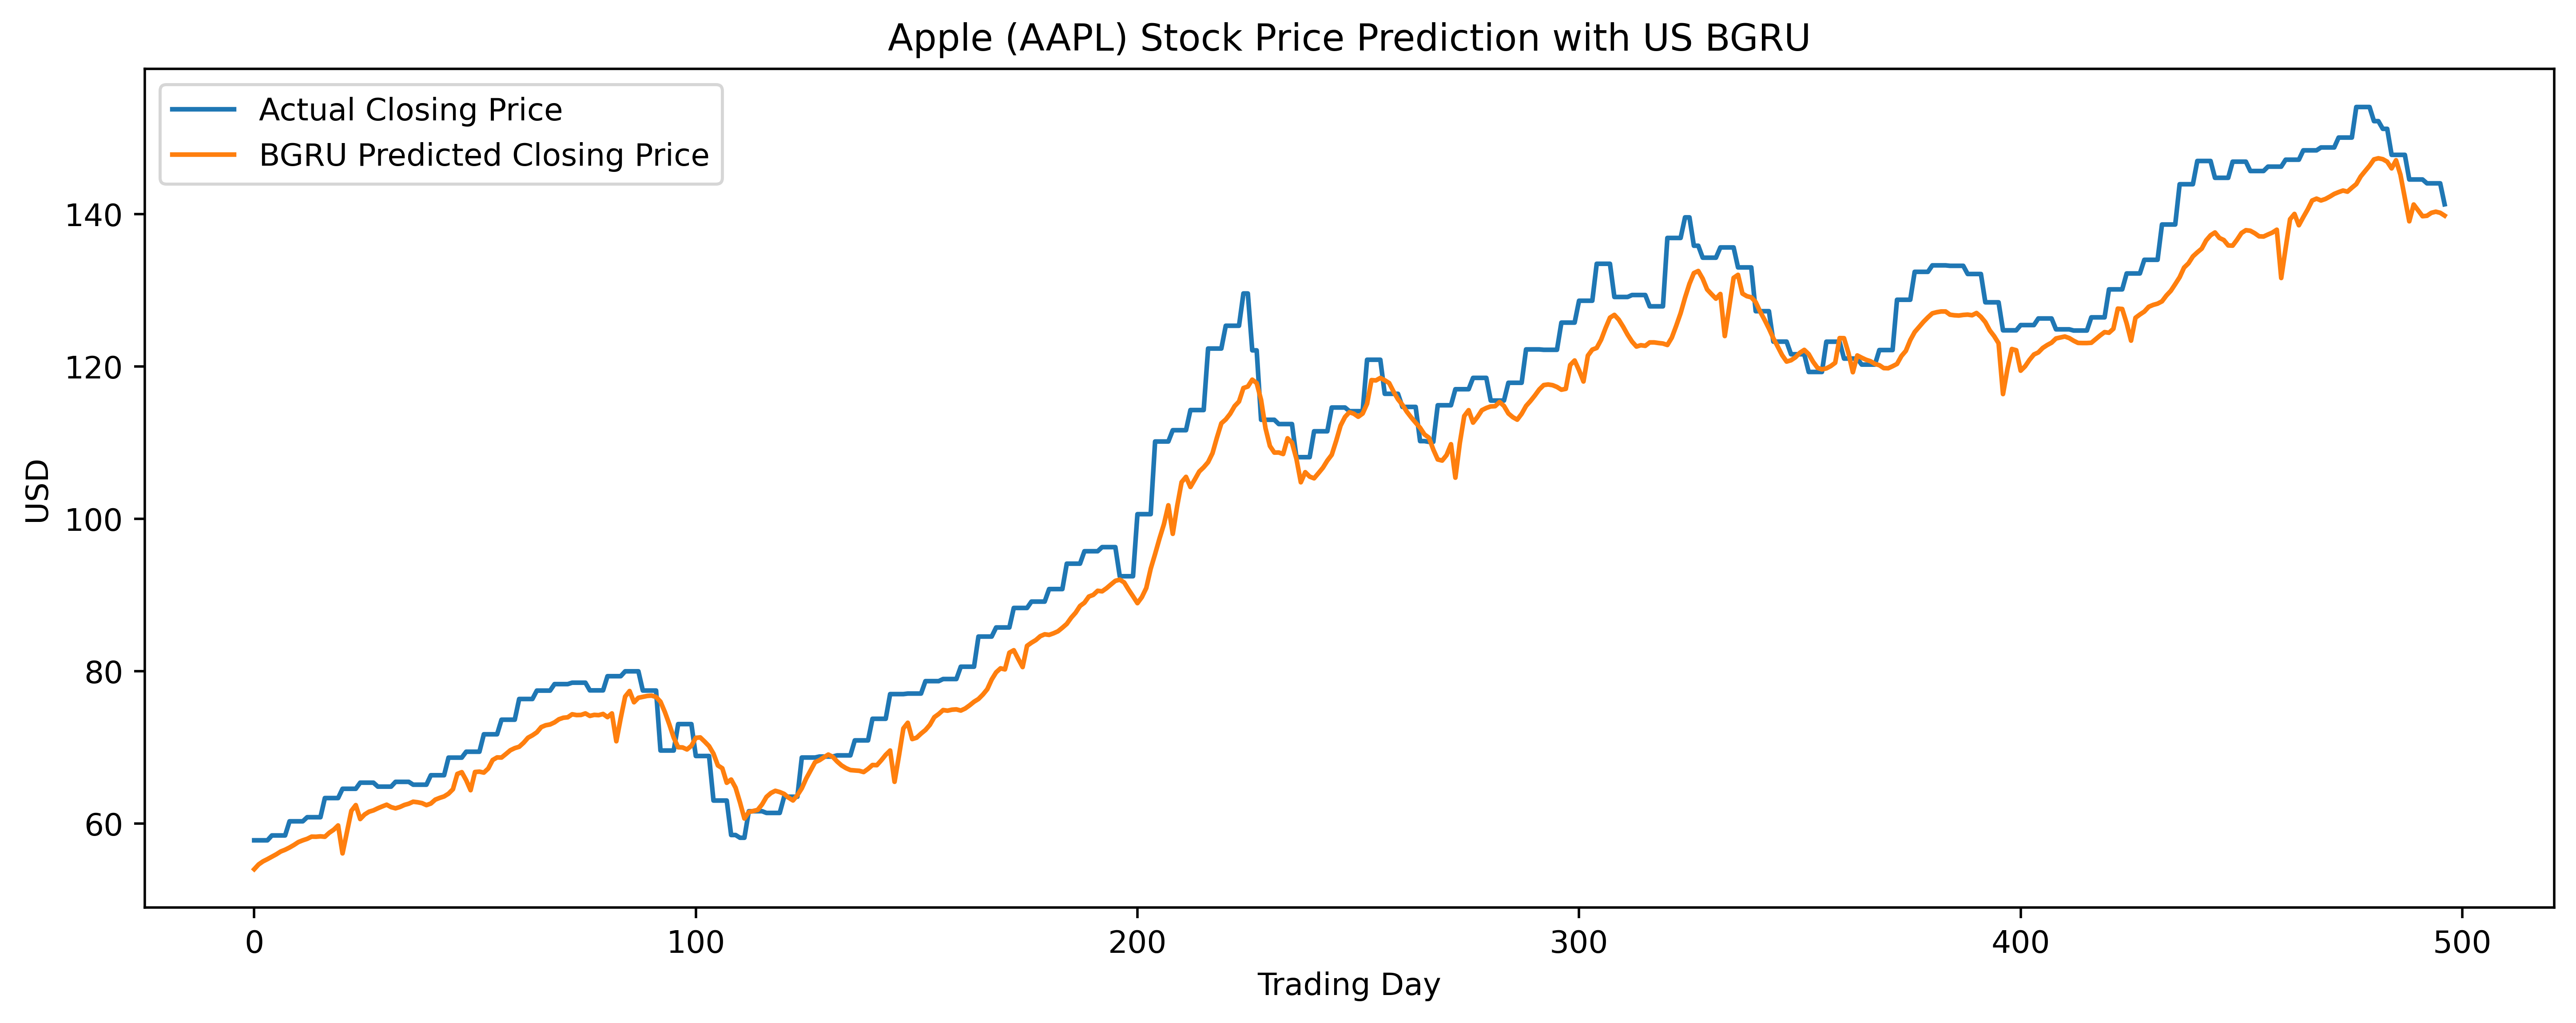

16/16 [==============================] - 0s 23ms/step - loss: 0.0048 - mean_absolute_error: 0.0405 - root_mean_squared_error: 0.0690 - mean_absolute_percentage_error: 83.0648

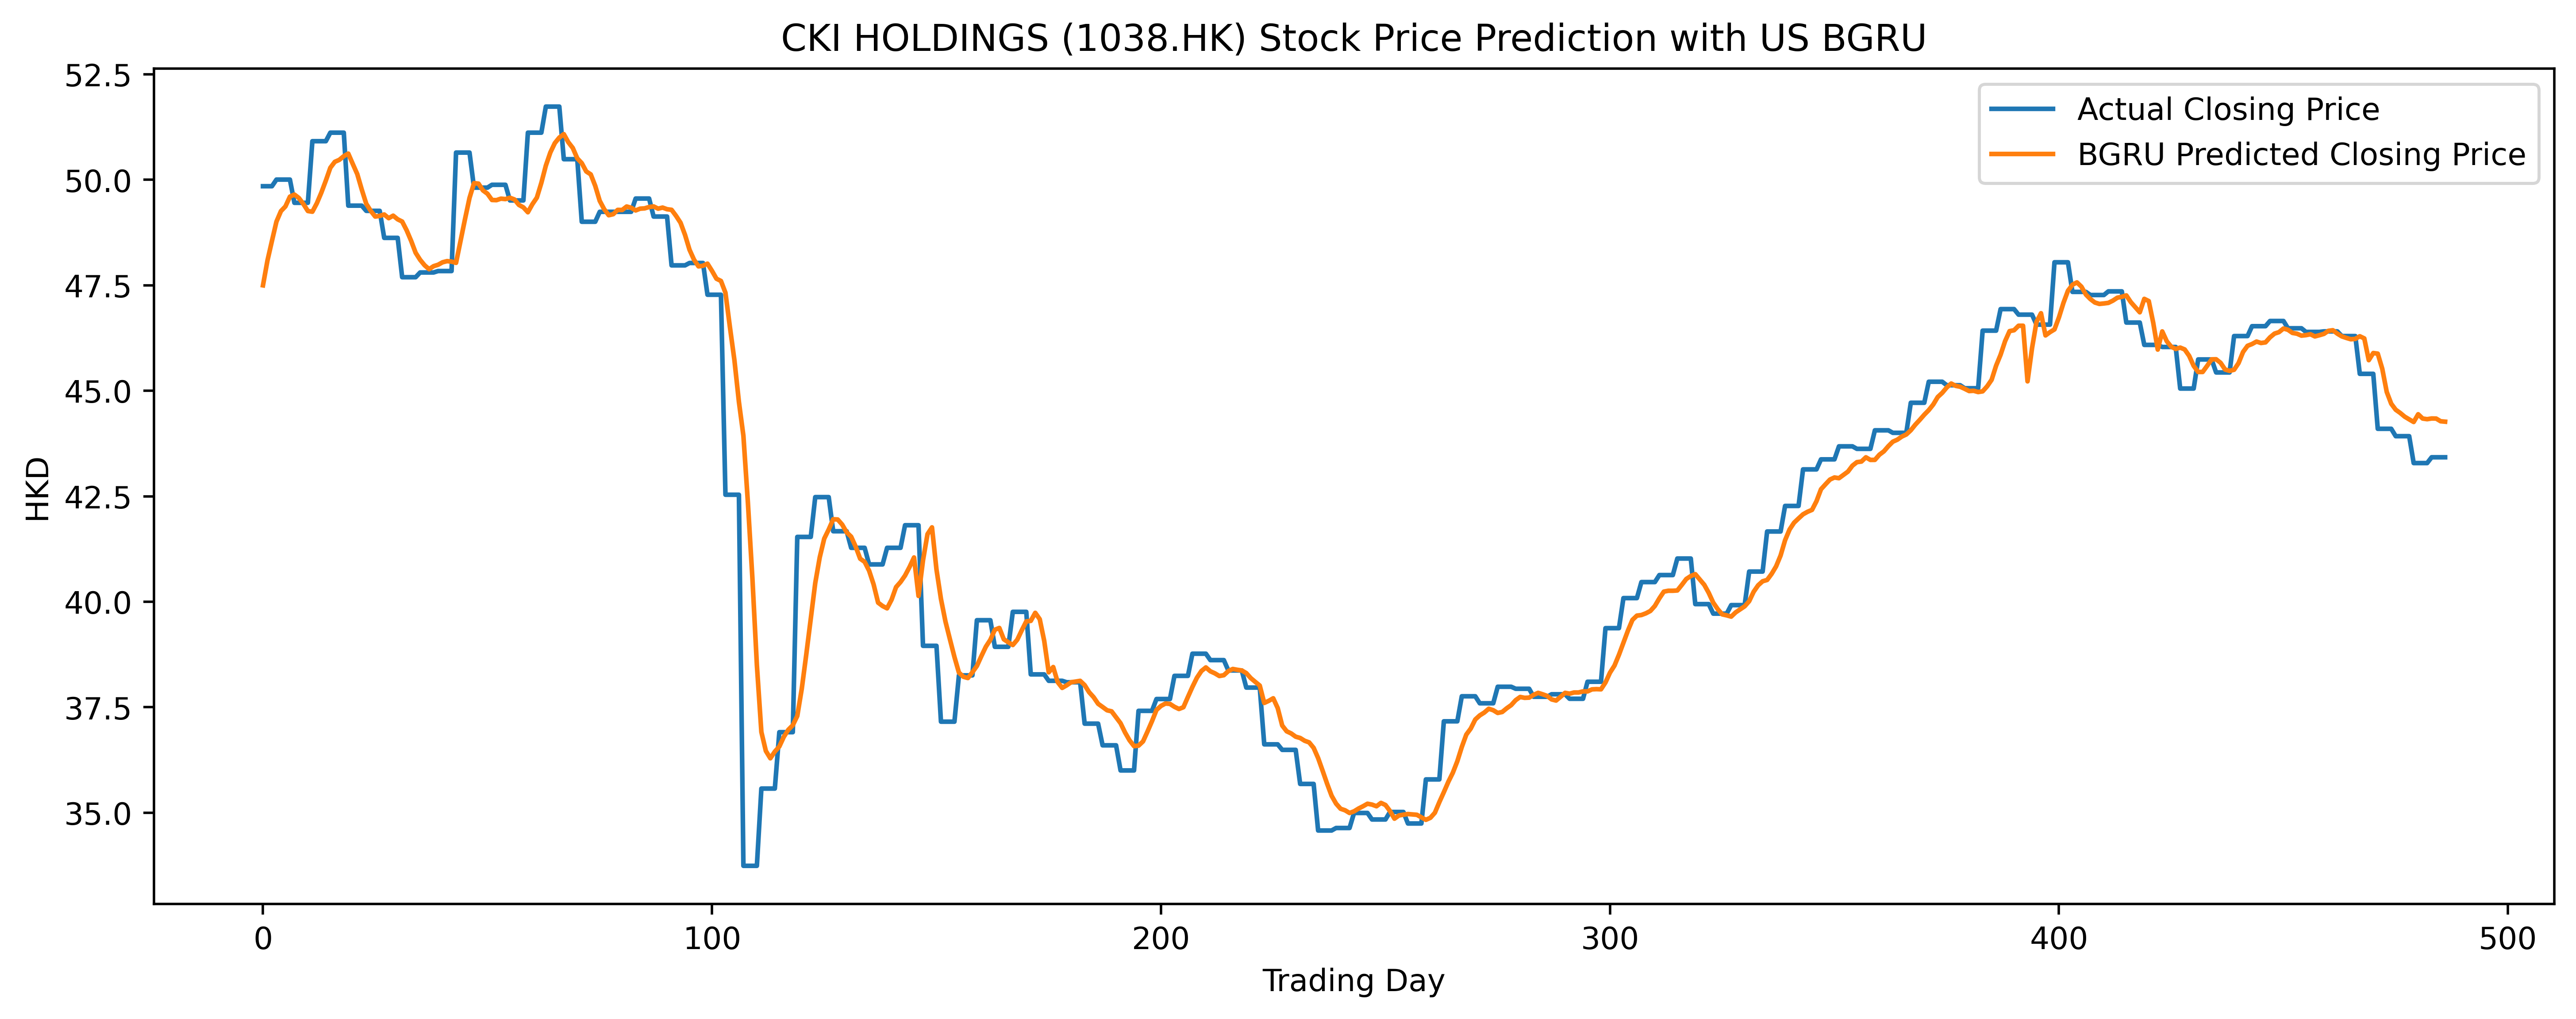

16/16 [==============================] - 0s 23ms/step - loss: 0.0048 - mean_absolute_error: 0.0589 - root_mean_squared_error: 0.0691 - mean_absolute_percentage_error: 70.1144

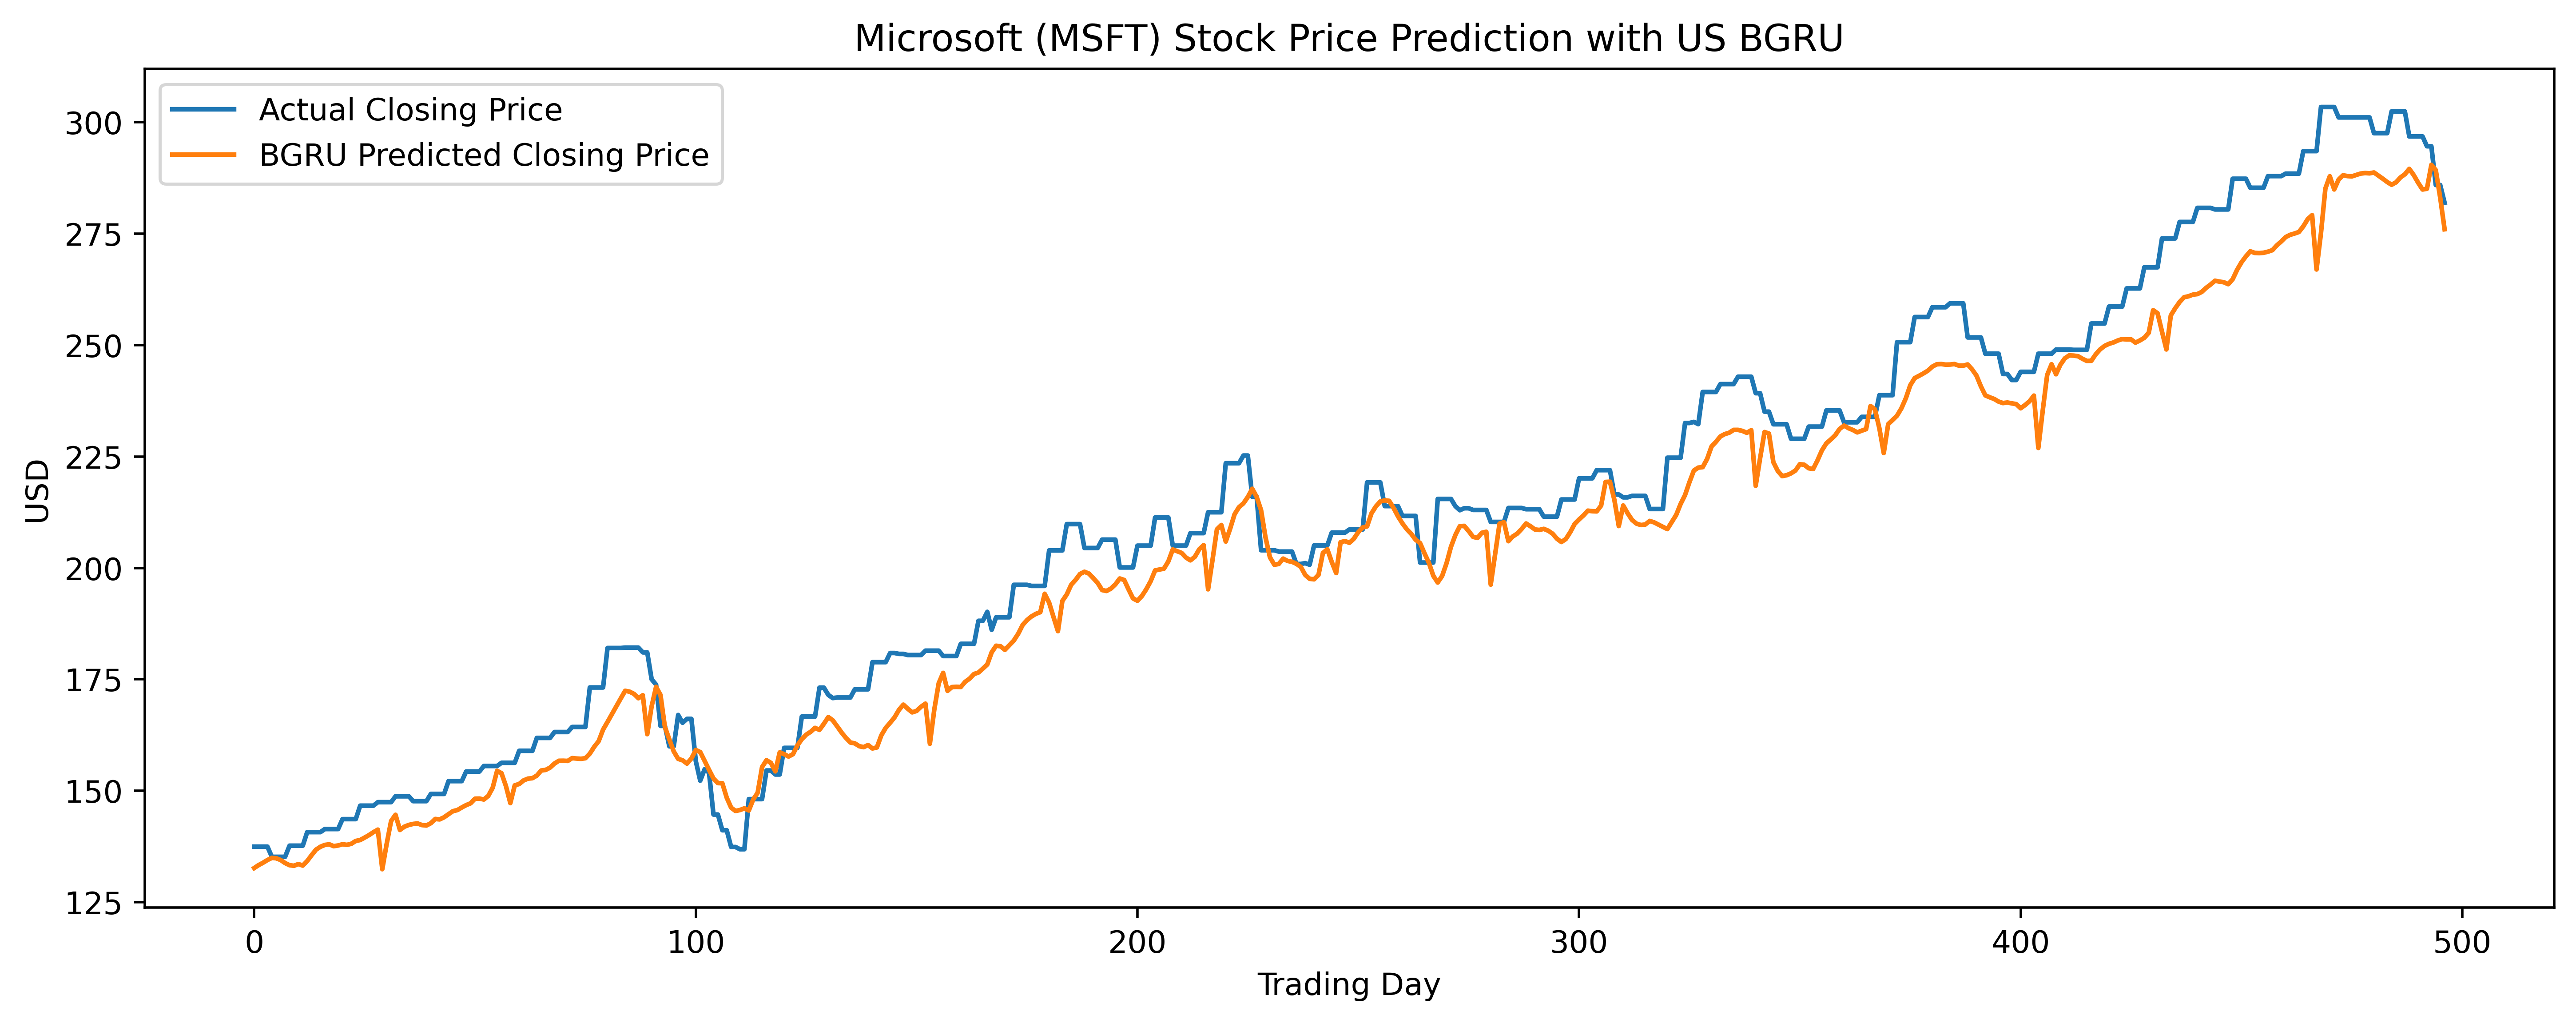

In [73]:
predict_and_evaluate(us_bgru, "BGRU", False)

##### GAN

In [ ]:
predict_and_evaluate(us_gan, "GAN", False)

#### Display the Dataframe of evaluation metrics

In [74]:
df_eva_metrics = pd.DataFrame(
    columns=["model", "stock"] + evaluation_fields_name,
    data=df_eva_metrics_list
)

df_eva_metrics

model    stock  loss (mean_squared_error)  mean_absolute_error  \
0   BGRU (HK)     TEAM                   0.018121             0.097447   
1   BGRU (HK)  2888.HK                   0.044868             0.162823   
2   BGRU (HK)  1299.HK                   0.011941             0.092265   
3   BGRU (HK)     AAPL                   0.008791             0.078223   
4   BGRU (HK)  1038.HK                   0.020306             0.116474   
5   BGRU (HK)     MSFT                   0.004523             0.054247   
6   BGRU (US)     TEAM                   0.005491             0.053419   
7   BGRU (US)  2888.HK                   0.010241             0.078039   
8   BGRU (US)  1299.HK                   0.004545             0.055210   
9   BGRU (US)     AAPL                   0.006400             0.067478   
10  BGRU (US)  1038.HK                   0.004759             0.040522   
11  BGRU (US)     MSFT                   0.004775             0.058866   

    root_mean_squared_error  mean_absolute_percentage_error  
0                  0.134616                        0.066609  
1                  0.211821                        0.066316  
2                  0.109276                        0.046122  
3                  0.093758                        0.052649  
4                  0.142501                        0.043425  
5                  0.067255                        0.034593  
6                  0.074103                        0.036087  
7                  0.101198                        0.033163  
8                  0.067418                        0.027813  
9                  0.079999                        0.046058  
10                 0.068986                        0.015925  
11                 0.069103                        0.039035